# XGBoost (Dataset in_vitro)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)
import xgboost as xgb
from xgboost import XGBClassifier
import shap
import optuna
from rdkit import DataStructs

## Molecule, Descriptor and Outlier Functions

In [5]:
def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs (Only critical)
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors


def compute_iqr_limits(df, factor=1.5):
    # Calculate IQR limits
    limits = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat - skip
        if iqr == 0 or np.isnan(iqr):
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        limits[col] = (lower, upper)
    return limits


def apply_iqr_limits(df, limits):
    # Apply the limits
    df_clipped = df.copy()
    for col, (lower, upper) in limits.items():
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped


def smiles_to_rdkit_fp(smiles, n_bits=256):
    # Molecule from SMILES
    mol, state = molecule_from_smiles(smiles)

    # If molecule is none
    if mol is None:
        return np.zeros(n_bits, dtype=int)

    # Compute RDKit fingerprint
    fp = Chem.RDKFingerprint(mol, fpSize=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr


## Dataset Processing

In [6]:
# Configuration
ORIG_DATASET = "datasets/in_vitro_3T3_in_chemico_dataset_homolumo_processed.xlsx"
SKIP_ROWS = 0
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
HOMO_COL = "HOMO_eV"
LUMO_COL = "LUMO_eV"
HL_GAP_COL = "HL_Gap_eV"
FULL_OUTPUT_DATASET = "in_vitro_3T3_dataset_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"

# Near constant threshold - tolerance
SIMILARITY_THRESHOLD = 0.90
# Correlation threshold
CORRELATION_THRESHOLD = 0.95

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

# Build descriptors
descriptor_rows = []
state_molecules = []
molecules = []

# Loop over the SMILES column
for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    # If molecule construction failed - empty placeholder
    if molecule is None:
        descriptor_rows.append({})
        continue
    # Calculate descriptors for each molecule
    descriptor_rows.append(calculate_descriptors(molecule))

# Convert list of dictionaries into dataframe
descriptor_data_all = pd.DataFrame(descriptor_rows)

# Add HOMO/LUMO/HL_Gap columns
extra_cols = [HOMO_COL, LUMO_COL, HL_GAP_COL]

descriptor_data_all[extra_cols] = dataset[extra_cols].reset_index(drop=True)

# Keep everything + status
output = pd.concat(
    [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)],
    axis=1
)
output["MoleculeStatus"] = state_molecules

# Output whole dataset with descriptors and state
with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Drop failed molecules - boolean array
molecules_right = []
for molecule in molecules:
    if molecule is not None:
        molecules_right.append(True)
    else:
        molecules_right.append(False)
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Take only numeric descriptor columns
X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
for column in X_full.columns:
    X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)

# Split dataset - train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Calculate medians for each column in train only
train_medians = X_train.median(numeric_only=True)

# Fill missing values in both train and test using those medians
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Compute constants on train only
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

# Drop from train and apply same drop to test
if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

# Compute absolute correlation matrix on training data
corr_matrix = X_train.corr().abs()
# Keep only upper triangle of the matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find columns to drop - correlation
high_corr_cols = []
for col in upper.columns:
    if any(upper[col] > CORRELATION_THRESHOLD):
        high_corr_cols.append(col)

# Drop from both train and test
if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated columns.")

# Compute IQR limits on training data
iqr_limits = compute_iqr_limits(X_train, factor=1.5)

# Apply limits to both train and test sets
X_train = apply_iqr_limits(X_train, iqr_limits)
X_test = apply_iqr_limits(X_test, iqr_limits)

X_train = pd.DataFrame(X_train, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test, columns=X_test.columns, index=X_test.index)

X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
print("First rows of train x:")
print(X_train.head().to_string(index=False))
print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
print("First rows of train y:")
print(y_train.head().to_string(index=False))
X_train.describe()

print("\nTrain set class counts:")
print(y_train.value_counts())
print("\nTrain set class ratio:")
print(y_train.value_counts(normalize=True))

print("\nTest set class counts:")
print(y_test.value_counts())
print("\nTest set class ratio:")
print(y_test.value_counts(normalize=True))

# Calculate fingerprint - added after all of processing
n_bits = 256
smiles_series = dataset_ok[SMILES_COL].astype(str)

fp_list = [smiles_to_rdkit_fp(s, n_bits=n_bits) for s in smiles_series]
fp_array = np.vstack(fp_list)

fp_cols = [f"RDKit_fp_{i}" for i in range(n_bits)]
fps_full = pd.DataFrame(fp_array, columns=fp_cols, index=dataset_ok.index)

# Align fingerprints with train/test indices
fp_train = fps_full.loc[X_train.index]
fp_test = fps_full.loc[X_test.index]

Full - Rows: 397/Columns: 232
                                                                                                   Name                                                                                                                                    IUPAC name CAS registry number      Structure  Phototoxicity                                                                     SMILES code                                                                                                                                                                              Sources  Note  HOMO_eV  LUMO_eV  HL_Gap_eV MoleculeStatus  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex      qed       SPS   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_L

## Base Model Train

In [7]:
base_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42
)
# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nModel performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Model performance:
Accuracy:  0.6750
Precision: 0.6667
Recall:    0.5946
F1 score:  0.6286
ROC AUC:   0.7945

Classification report:
              precision    recall  f1-score   support

           0      0.681     0.744     0.711        43
           1      0.667     0.595     0.629        37

    accuracy                          0.675        80
   macro avg      0.674     0.669     0.670        80
weighted avg      0.674     0.675     0.673        80



## Feature Selection

PermutationExplainer explainer: 317it [00:27,  8.90it/s]                         
/tmp/ipykernel_60813/335949761.py:38: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


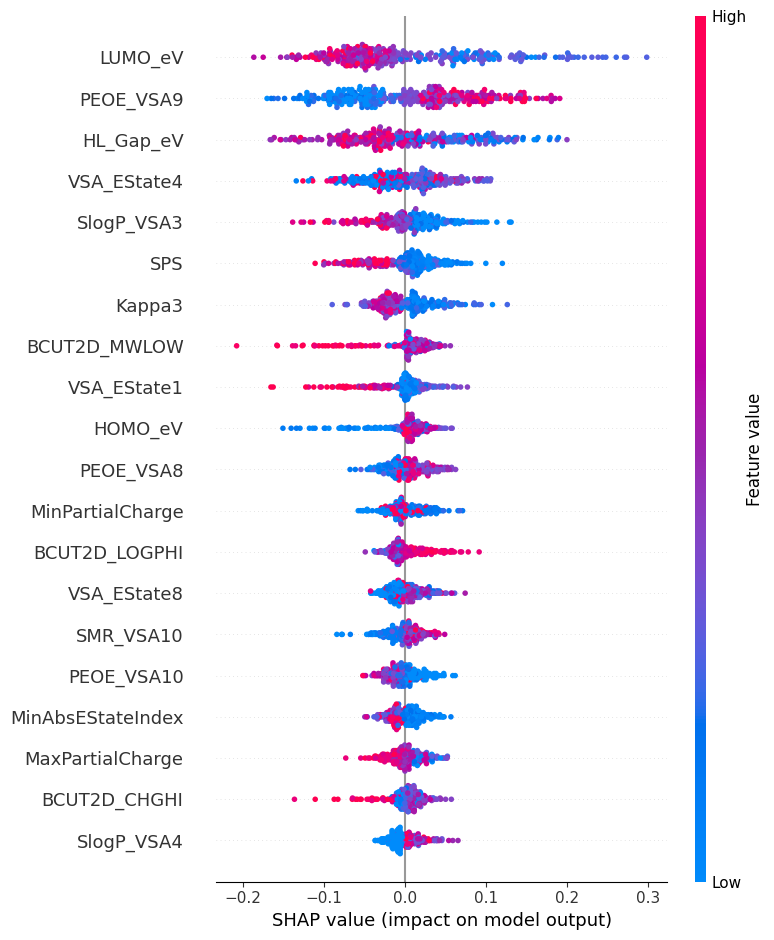

In [8]:
# SHAP features
# Prediction function for SHAP
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train)

# Each row has values for features
shap_values = shap_result.values

# Mean absolute SHAP value per feature (importance)
shap_importance = np.abs(shap_values).mean(axis=0)
shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(ascending=False)

# XGBoost features
xgb_importance = pd.Series(base_model.feature_importances_, index=X_train.columns)
xgb_features = xgb_importance.sort_values(ascending=False)

# K-Best - Anova features
kbest = SelectKBest(score_func=f_classif, k='all')
kbest.fit(X_train, y_train)
kbest_scores = pd.Series(kbest.scores_, index=X_train.columns).fillna(0.0)
kbest_features = kbest_scores.sort_values(ascending=False)

# Lasso features
lasso = LogisticRegression(
    penalty='l1',
    C=1.0,
    solver='liblinear',
    max_iter=5000
)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# Plot
shap.summary_plot(shap_values, X_train)

In [9]:
shap_features.head(30)

LUMO_eV              0.074718
PEOE_VSA9            0.066847
HL_Gap_eV            0.059625
VSA_EState4          0.037272
SlogP_VSA3           0.029595
SPS                  0.028683
Kappa3               0.025384
BCUT2D_MWLOW         0.023628
VSA_EState1          0.020626
HOMO_eV              0.019315
PEOE_VSA8            0.017330
MinPartialCharge     0.016127
BCUT2D_LOGPHI        0.015570
VSA_EState8          0.015081
SMR_VSA10            0.014553
PEOE_VSA10           0.014206
MinAbsEStateIndex    0.014042
MaxPartialCharge     0.014014
BCUT2D_CHGHI         0.013832
SlogP_VSA4           0.013089
PEOE_VSA7            0.012276
BalabanJ             0.012014
EState_VSA2          0.011672
qed                  0.011409
VSA_EState5          0.011272
VSA_EState7          0.010984
EState_VSA6          0.010717
Ipc                  0.010017
fr_methoxy           0.009608
EState_VSA3          0.009149
dtype: float64

In [10]:
xgb_features.head(30)

Ipc                      0.077450
fr_para_hydroxylation    0.039836
PEOE_VSA4                0.038447
fr_aryl_methyl           0.036874
EState_VSA7              0.026000
SMR_VSA10                0.022238
SMR_VSA6                 0.020782
BCUT2D_CHGHI             0.020678
HL_Gap_eV                0.020533
fr_ether                 0.020031
fr_Ar_OH                 0.019606
PEOE_VSA12               0.018150
BCUT2D_MWLOW             0.016630
PEOE_VSA11               0.016522
VSA_EState4              0.016364
SlogP_VSA12              0.016212
SlogP_VSA7               0.015987
MolWt                    0.015971
NumAmideBonds            0.015438
PEOE_VSA2                0.015437
SlogP_VSA3               0.015397
BCUT2D_LOGPHI            0.014742
SMR_VSA5                 0.014481
NumAtomStereoCenters     0.014316
fr_halogen               0.013999
SlogP_VSA4               0.013908
MinEStateIndex           0.013852
BCUT2D_LOGPLOW           0.013569
EState_VSA10             0.013283
fr_bicyclic   

In [11]:
kbest_features.head(30)

HL_Gap_eV                  32.173950
RingCount                  22.734369
PEOE_VSA9                  21.615942
LUMO_eV                    21.048179
fr_bicyclic                19.328980
NumAromaticRings           18.854852
SlogP_VSA8                 17.986763
SMR_VSA7                   15.842137
SMR_VSA10                  15.787891
BertzCT                    15.617670
NumAromaticCarbocycles     15.193002
fr_pyridine                14.534442
BCUT2D_LOGPHI              14.416030
MolWt                      11.861958
PEOE_VSA8                  11.780266
MolLogP                    11.397205
EState_VSA7                10.297961
VSA_EState6                10.010219
FractionCSP3                9.513527
fr_para_hydroxylation       9.304232
BCUT2D_CHGLO                9.135780
SlogP_VSA6                  8.953220
PEOE_VSA7                   8.870872
BCUT2D_MWLOW                8.670939
AvgIpc                      8.234820
NumHeterocycles             8.228272
NumAromaticHeterocycles     7.851495
S

In [12]:
lasso_features.head(30)

NumAliphaticRings                  2.168653
NumAmideBonds                      2.103710
fr_Ar_N                            1.794342
BalabanJ                           1.445539
fr_methoxy                         1.229629
NumSaturatedCarbocycles            0.978286
fr_pyridine                        0.812112
fr_Al_OH                           0.761787
fr_halogen                         0.728750
RingCount                          0.700239
FpDensityMorgan3                   0.681928
VSA_EState5                        0.652123
SPS                                0.631241
Kappa3                             0.563184
HL_Gap_eV                          0.488645
NumUnspecifiedAtomStereoCenters    0.472431
MolLogP                            0.354672
fr_aryl_methyl                     0.301660
PEOE_VSA14                         0.281446
PEOE_VSA11                         0.261994
SlogP_VSA1                         0.248583
PEOE_VSA9                          0.235762
fr_NH0                          

## Model SHAP Features Tuning (Randomized Search CV)


=== Testing top 5 features ===


Best parameters: {'subsample': 0.7, 'n_estimators': 70, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Accuracy: 0.662 | ROC-AUC: 0.675

=== Testing top 6 features ===
Best parameters: {'subsample': 0.7, 'n_estimators': 80, 'max_depth': 4, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Accuracy: 0.637 | ROC-AUC: 0.639

=== Testing top 7 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 80, 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 0.7}
Accuracy: 0.600 | ROC-AUC: 0.603

=== Testing top 8 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 30, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Accuracy: 0.650 | ROC-AUC: 0.691

=== Testing top 9 features ===
Best parameters: {'subsample': 0.7, 'n_estimators': 20, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Accuracy: 0.662 | ROC-AUC: 0.650

=== Testing top 10 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 20, 'max_depth': 7, 'learni

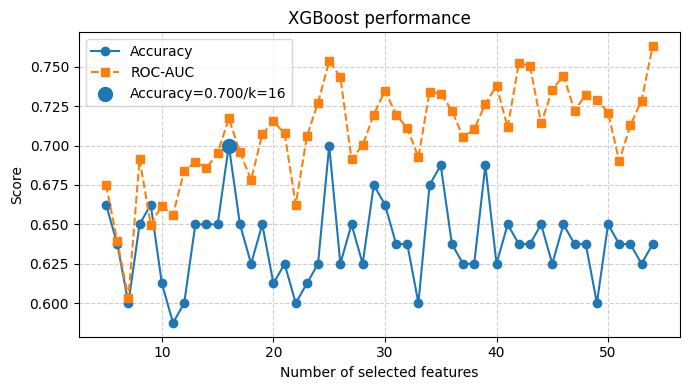


Accuracy = 0.700/ROC-AUC = 0.717/k = 16


In [13]:
ranking = shap_features

param_dist = {
    "n_estimators": np.arange(20, 90, 10),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
}

results = []
for k in range(5, 55, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=200,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model SHAP Features Tuning (Randomized Search CV) - Fingerprint

In [14]:
# Select the best_k features
top_feats_best = ranking.head(best_k).index.tolist()
print(f"\nUsing best_k = {best_k} features: {len(top_feats_best)} selected.")

X_train_sel = X_train[top_feats_best].copy()
X_test_sel = X_test[top_feats_best].copy()

# Concatenate best_k descriptors + fingerprints
X_train_final = pd.concat([X_train_sel, fp_train], axis=1)
X_test_final = pd.concat([X_test_sel, fp_test], axis=1)

print(f"Final train shape with fingerprints: {X_train_final.shape}")
print(f"Final test shape with fingerprints:  {X_test_final.shape}")

# RandomizedSearchCV
xgb_clf_final = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

search_final = RandomizedSearchCV(
    estimator=xgb_clf_final,
    param_distributions=param_dist,
    n_iter=200,
    scoring="accuracy",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

search_final.fit(X_train_final, y_train)

best_model_final = search_final.best_estimator_
y_pred_final = best_model_final.predict(X_test_final)
y_prob_final = best_model_final.predict_proba(X_test_final)[:, 1]

acc_final = accuracy_score(y_test, y_pred_final)
auc_final = roc_auc_score(y_test, y_prob_final)

print("\n=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===")
print(f"Best parameters: {search_final.best_params_}")
print(f"Test Accuracy: {acc_final:.3f}")
print(f"Test ROC-AUC: {auc_final:.3f}")


Using best_k = 16 features: 16 selected.
Final train shape with fingerprints: (316, 272)
Final test shape with fingerprints:  (80, 272)

=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===
Best parameters: {'subsample': 0.7, 'n_estimators': 80, 'max_depth': 4, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Test Accuracy: 0.637
Test ROC-AUC: 0.680


## Model XGB Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.7, 'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.562 | ROC-AUC: 0.628

=== Testing top 6 features ===
Best parameters: {'subsample': 0.9, 'n_estimators': 40, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Accuracy: 0.625 | ROC-AUC: 0.691

=== Testing top 7 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 20, 'max_depth': 4, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Accuracy: 0.637 | ROC-AUC: 0.703

=== Testing top 8 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 70, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.7}
Accuracy: 0.675 | ROC-AUC: 0.734

=== Testing top 9 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Accuracy: 0.575 | ROC-AUC: 0.652

=== Testing top 10 features ===
Best parameters: {'subsample': 0.7, 'n_estimat

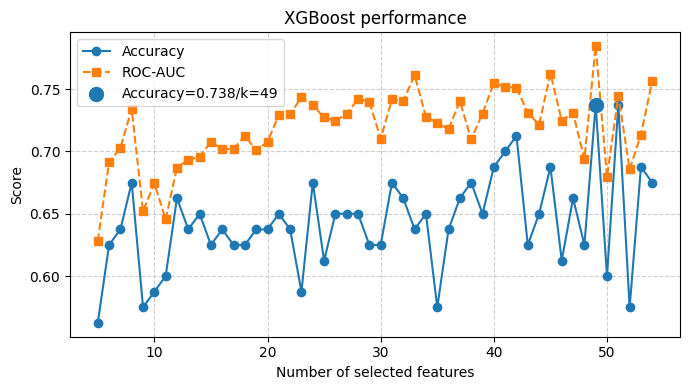


Accuracy = 0.738/ROC-AUC = 0.784/k = 49


In [15]:
ranking = xgb_features

param_dist = {
    "n_estimators": np.arange(20, 90, 10),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
}

results = []
for k in range(5, 55, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=200,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model XGB Features Tuning (Randomized Search CV) - Fingerprint

In [16]:
# Select the best_k features
top_feats_best = ranking.head(best_k).index.tolist()
print(f"\nUsing best_k = {best_k} features: {len(top_feats_best)} selected.")

X_train_sel = X_train[top_feats_best].copy()
X_test_sel = X_test[top_feats_best].copy()

# Concatenate best_k descriptors + fingerprints
X_train_final = pd.concat([X_train_sel, fp_train], axis=1)
X_test_final = pd.concat([X_test_sel, fp_test], axis=1)

print(f"Final train shape with fingerprints: {X_train_final.shape}")
print(f"Final test shape with fingerprints:  {X_test_final.shape}")

# RandomizedSearchCV
xgb_clf_final = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

search_final = RandomizedSearchCV(
    estimator=xgb_clf_final,
    param_distributions=param_dist,
    n_iter=200,
    scoring="accuracy",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

search_final.fit(X_train_final, y_train)

best_model_final = search_final.best_estimator_
y_pred_final = best_model_final.predict(X_test_final)
y_prob_final = best_model_final.predict_proba(X_test_final)[:, 1]

acc_final = accuracy_score(y_test, y_pred_final)
auc_final = roc_auc_score(y_test, y_prob_final)

print("\n=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===")
print(f"Best parameters: {search_final.best_params_}")
print(f"Test Accuracy: {acc_final:.3f}")
print(f"Test ROC-AUC: {auc_final:.3f}")


Using best_k = 49 features: 49 selected.
Final train shape with fingerprints: (316, 305)
Final test shape with fingerprints:  (80, 305)

=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===
Best parameters: {'subsample': 0.7, 'n_estimators': 40, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Test Accuracy: 0.662
Test ROC-AUC: 0.725


## Model KBEST Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.9, 'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 0.7}
Accuracy: 0.637 | ROC-AUC: 0.652

=== Testing top 6 features ===
Best parameters: {'subsample': 0.7, 'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.588 | ROC-AUC: 0.642

=== Testing top 7 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 20, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Accuracy: 0.588 | ROC-AUC: 0.625

=== Testing top 8 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 30, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Accuracy: 0.650 | ROC-AUC: 0.693

=== Testing top 9 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 30, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Accuracy: 0.650 | ROC-AUC: 0.723

=== Testing top 10 features ===
Best parameters: {'subsample': 0.7, 'n_estimato

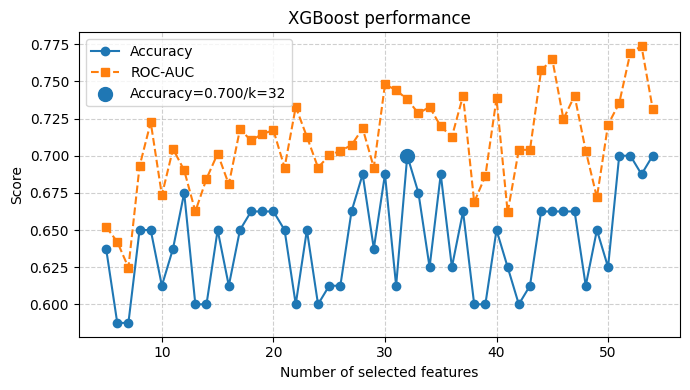


Accuracy = 0.700/ROC-AUC = 0.738/k = 32


In [17]:
ranking = kbest_features

param_dist = {
    "n_estimators": np.arange(20, 90, 10),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
}

results = []
for k in range(5, 55, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=200,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model KBEST Features Tuning (Randomized Search CV) - Fingerprint

In [18]:
# Select the best_k features
top_feats_best = ranking.head(best_k).index.tolist()
print(f"\nUsing best_k = {best_k} features: {len(top_feats_best)} selected.")

X_train_sel = X_train[top_feats_best].copy()
X_test_sel = X_test[top_feats_best].copy()

# Concatenate best_k descriptors + fingerprints
X_train_final = pd.concat([X_train_sel, fp_train], axis=1)
X_test_final = pd.concat([X_test_sel, fp_test], axis=1)

print(f"Final train shape with fingerprints: {X_train_final.shape}")
print(f"Final test shape with fingerprints:  {X_test_final.shape}")

# RandomizedSearchCV
xgb_clf_final = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

search_final = RandomizedSearchCV(
    estimator=xgb_clf_final,
    param_distributions=param_dist,
    n_iter=200,
    scoring="accuracy",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

search_final.fit(X_train_final, y_train)

best_model_final = search_final.best_estimator_
y_pred_final = best_model_final.predict(X_test_final)
y_prob_final = best_model_final.predict_proba(X_test_final)[:, 1]

acc_final = accuracy_score(y_test, y_pred_final)
auc_final = roc_auc_score(y_test, y_prob_final)

print("\n=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===")
print(f"Best parameters: {search_final.best_params_}")
print(f"Test Accuracy: {acc_final:.3f}")
print(f"Test ROC-AUC: {auc_final:.3f}")


Using best_k = 32 features: 32 selected.
Final train shape with fingerprints: (316, 288)
Final test shape with fingerprints:  (80, 288)

=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===
Best parameters: {'subsample': 0.6, 'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Test Accuracy: 0.613
Test ROC-AUC: 0.679


## Model LASSO Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Accuracy: 0.537 | ROC-AUC: 0.556

=== Testing top 6 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Accuracy: 0.562 | ROC-AUC: 0.635

=== Testing top 7 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': 60, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Accuracy: 0.575 | ROC-AUC: 0.639

=== Testing top 8 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Accuracy: 0.575 | ROC-AUC: 0.599

=== Testing top 9 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Accuracy: 0.562 | ROC-AUC: 0.626

=== Testing top 10 features ===
Best parameters: {'subsample': 0.9, 'n_esti

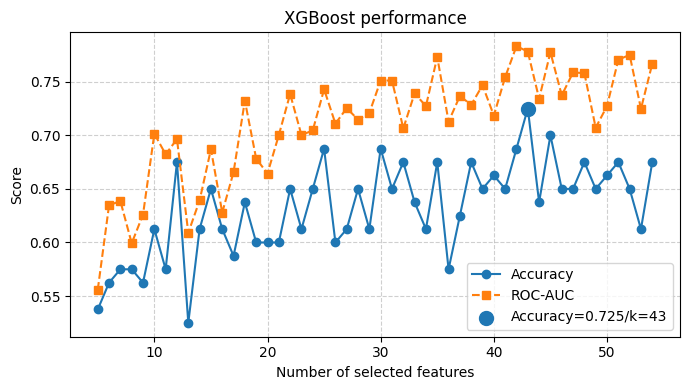


Accuracy = 0.725/ROC-AUC = 0.778/k = 43


In [19]:
ranking = lasso_features

param_dist = {
    "n_estimators": np.arange(20, 90, 10),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
}

results = []
for k in range(5, 55, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=200,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model LASSO Features Tuning (Randomized Search CV) - Fingerprint

In [20]:
# Select the best_k features
top_feats_best = ranking.head(best_k).index.tolist()
print(f"\nUsing best_k = {best_k} features: {len(top_feats_best)} selected.")

X_train_sel = X_train[top_feats_best].copy()
X_test_sel = X_test[top_feats_best].copy()

# Concatenate best_k descriptors + fingerprints
X_train_final = pd.concat([X_train_sel, fp_train], axis=1)
X_test_final = pd.concat([X_test_sel, fp_test], axis=1)

print(f"Final train shape with fingerprints: {X_train_final.shape}")
print(f"Final test shape with fingerprints:  {X_test_final.shape}")

# RandomizedSearchCV
xgb_clf_final = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

search_final = RandomizedSearchCV(
    estimator=xgb_clf_final,
    param_distributions=param_dist,
    n_iter=200,
    scoring="accuracy",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

search_final.fit(X_train_final, y_train)

best_model_final = search_final.best_estimator_
y_pred_final = best_model_final.predict(X_test_final)
y_prob_final = best_model_final.predict_proba(X_test_final)[:, 1]

acc_final = accuracy_score(y_test, y_pred_final)
auc_final = roc_auc_score(y_test, y_prob_final)

print("\n=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===")
print(f"Best parameters: {search_final.best_params_}")
print(f"Test Accuracy: {acc_final:.3f}")
print(f"Test ROC-AUC: {auc_final:.3f}")


Using best_k = 43 features: 43 selected.
Final train shape with fingerprints: (316, 299)
Final test shape with fingerprints:  (80, 299)

=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===
Best parameters: {'subsample': 0.7, 'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.3, 'colsample_bytree': 1.0}
Test Accuracy: 0.700
Test ROC-AUC: 0.774
